In [1]:
import pickle
import numpy as np
import scipy.interpolate as spi
import matplotlib.pyplot as plt
%matplotlib inline

import flayer
import particle_evolution
import feo_thermodynamics as feot

# We have some annoying warnings - I think from llvm bug - fix then remove this
import warnings
warnings.filterwarnings("ignore")

In [2]:
def run_flayer_case(input_data, filename=None):
    """
    Run a single f-layer case with input from dictionary, optionally save
    
    input_data: a dictionary of input data 
    filename: optional string, if present save case to file
    
    Returns
    output_data: a dictionary of input and output data"""
    
    solutions, analysis_radii, particle_densities, calculated_seperation, solid_vf, \
        particle_radii, partial_particle_densities, growth_rate, opt_xl, crit_nuc_radii, nucleation_rates, \
        vf_ratio = flayer.flayer_case(**input_data)
    
    output_data = dict(input_data)
    
    output_data["solutions"] = solutions
    output_data["analysis_radii"] = analysis_radii
    output_data["particle_densities"] = particle_densities
    output_data["calculated_seperation"] = calculated_seperation
    output_data["solid_vf"] = solid_vf
    output_data["particle_radii"] = particle_radii
    output_data["partial_particle_densities"] = partial_particle_densities
    output_data["growth_rate"] = growth_rate
    output_data["opt_xl"] = opt_xl
    output_data["crit_nuc_radii"] = crit_nuc_radii
    output_data["nucleation_rates"] = nucleation_rates
    output_data["vf_ratio"] = vf_ratio
    
    if filename is not None:
        with open(filename, 'wb') as f:
            pickle.dump(output_data, f)
    
    return output_data


def load_case_data(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

def plot_case_single_solution(index, data):
    """
    Create plot of time evolution for nucleation from a single depth, given case data and index
    
    index: integer nucleation index
    data: dictioary of compleated f-layer case. If a string read from pickle file
    """     
    tfunc, tafunc, xfunc, pfunc, gfunc = flayer.setup_flayer_functions(**data)
    xl_func = spi.interp1d(data["analysis_radii"], data["opt_xl"], fill_value='extrapolate')

    particle_evolution.plot_particle_evolution_time(data["solutions"][index], xl_func, tfunc, pfunc, data['chemical_diffusivity'],
                                                    data['growth_prefactor'], gfunc, data['kinematic_viscosity'])

In [3]:
def plot_case_csd_nuc(particle_radii, analysis_radii, partial_particle_densities,
                      crit_nuc_radii, nucleation_rates, **other_data):

    max_particle_radius = particle_radii[particle_radii > 0.0].max()
    min_particle_radius = particle_radii[particle_radii > 0.0].min()
    print("Particle radii between {:.3g} and {:.3g} m".format(max_particle_radius, min_particle_radius))

    particle_size_distributions = []
    edges = None
    binsin = np.linspace(min_particle_radius, max_particle_radius, 20)

    for i, r in enumerate(analysis_radii):
        csd, edg = np.histogram(particle_radii[i,:], 
                                weights=partial_particle_densities[i,:],
                                range=(min_particle_radius, max_particle_radius),
                                bins=binsin)
        if edges is None:
            edges = edg
        else:
            assert np.array_equal(edges, edg)
    
        particle_size_distributions.append(csd)

    csd = np.array(particle_size_distributions)

    def _sciformat(x, pos=None):
        if x == 0:
            return "0.0"
        scistr = "{:E}".format(x)
        vals = scistr.split('E')
        fmttick = "${:.1f}".format(float(vals[0])) + r"\times 10^{" + "{}".format(int(vals[1])) + "}$"
        return fmttick

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharex='col')
    fig.subplots_adjust(hspace=0, wspace=0.1)

    ax = axs[0,0]
    im = ax.imshow(csd[1:,:].T, aspect='auto', interpolation='none', 
                   cmap=plt.get_cmap('Greys'), origin='lower', 
                   extent=[analysis_radii[1]/1000.0, analysis_radii[-1]/1000.0,
                           edges[0], edges[-1]]) #, norm=colors.LogNorm())
    ax.set_ylabel('Particle radius (m)')
    ax.set_xlabel('Radius (km)')
    #ax.set_yscale('log')

    cb = plt.colorbar(im, ax=ax, location='top')
    cb.set_label('Number of particles per m$^{3}$')
    cb.ax.xaxis.set_major_formatter(_sciformat)

    ax = axs[1,0]
    ax.plot(analysis_radii[1:-1]/1000.0, csd[1:-1,:].sum(axis=1))

    ax.set_xlabel('Radius (km)')
    ax.set_ylabel('Total number of particles per m$^3$')
    ax.yaxis.set_major_formatter(_sciformat)

    ax = axs[0, 1]
    ax.plot(analysis_radii[1:-1]/1000.0, nucleation_rates[1:-1])
    ax.yaxis.set_major_formatter(_sciformat)
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel('Nucleation rate (m$^{-3}$ s$^{-1}$)')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position("right")
    #ax.set_yscale('log')

    ax = axs[1, 1]
    ax.plot(analysis_radii[1:-1]/1000.0, crit_nuc_radii[1:-1])
    ax.set_xlabel('Radius (km)')
    ax.set_ylabel('Critical radius for nucleation (m)')
    ax.set_yscale('log')
    ax.yaxis.set_ticks_position('right')
    ax.yaxis.set_label_position("right")

    plt.show()

In [4]:
def plot_case_setup(r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 
                    delta_t_icb, xfe_outer_core, xfe_icb, **kwargs):
    
    # Generate the functions for temperautre,
    # composition, pressure and gravity
    tfunc, atfunc, xfunc, pfunc, \
        gfunc = flayer.setup_flayer_functions(r_icb, r_cmb, f_layer_thickness, 
                                              gruneisen_parameter, delta_t_icb,
                                              xfe_outer_core, xfe_icb)

    print("Temperature at CMB is", tfunc(r_cmb), "K")
    print("Temberature at top of F-layer is", tfunc(r_icb+f_layer_thickness), "K")
    print("Temberature at ICB is", tfunc(r_icb), "K")

    # Interpolate onto radius for plotting
    rs = np.linspace(r_icb, r_icb+500.0E3)
    ts = tfunc(rs)
    ats = atfunc(rs)
    ps = pfunc(rs)
    xs = xfunc(rs)
    # Find the P-X dependent liquidus (storing the temperature at each point)
    tl = feot.find_liquidus(xs, ps)


    # Plot the F-layer setup alongside the liquidus
    fig, ax1 = plt.subplots(figsize=(6,6), tight_layout=True)

    color = 'tab:red'
    ax1.set_xlabel('Radius (km)')
    ax1.set_ylabel('Temperature (K)', color=color)
    ax1.plot(rs/1000.0, ts, color=color)
    ax1.plot(rs/1000.0, ats, color=color, ls='--')
    ax1.plot(rs/1000.0, tl, color='k', ls=':')

    ax1.tick_params(axis='y', labelcolor=color)
    #ax1.set_ylim([5900, 6200])

    ax2 = ax1.twinx()  

    color = 'tab:blue'
    ax2.set_ylabel('Pressure (GPs)', color=color)  
    ax2.plot(rs/1000.0, ps, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([280, 330])

    fig.tight_layout()  
    plt.show()

In [5]:
def plot_case_solid_frac(analysis_radii, r_icb, r_cmb, f_layer_thickness, gruneisen_parameter, 
                    delta_t_icb, xfe_outer_core, xfe_icb, solid_vf, **kwargs):

    tfunc, atfunc, xfunc, pfunc, \
        gfunc = flayer.setup_flayer_functions(r_icb, r_cmb, f_layer_thickness, 
                                              gruneisen_parameter, delta_t_icb,
                                              xfe_outer_core, xfe_icb)

    fig, axs = plt.subplots(ncols=2, figsize=(12,6), tight_layout=True)
    ax = axs[0]
    ax.plot(analysis_radii[1:-1]/1000.0, solid_vf[1:-1], label='Non-equilibrium')

    ax.plot(analysis_radii[1:-1]/1000.0, feot.volume_fraction_solid(xfunc(analysis_radii[1:-1]), 
                                                                    pfunc(analysis_radii[1:-1]), 
                                                                    tfunc(analysis_radii[1:-1])), label='equilibriun')
    ax.set_yscale("log", nonpositive='clip')
    ax.set_ylabel('Volume fraction solid')
    ax.set_xlabel('Radius (km)')
    ax.legend()

    ax = axs[1]
    ax.plot(analysis_radii[1:-1]/1000.0, 
        solid_vf[1:-1] / feot.volume_fraction_solid(xfunc(analysis_radii[1:-1]), 
                                                                pfunc(analysis_radii[1:-1]), 
                                                                tfunc(analysis_radii[1:-1])))
    ax.set_ylabel('Fraction of equilibrium solid volume')
    ax.set_xlabel('Radius (km)')

    plt.show()

In [6]:
input_parameters = {'f_layer_thickness': 200.0E3,
                    'delta_t_icb': 10.0,
                    'xfe_outer_core': 0.92,
                    'xfe_icb': 0.92,
                    'growth_prefactor': 150.0,
                    'chemical_diffusivity': 1.0E-9,
                    'kinematic_viscosity': 1.0E-6,
                    'i0': 1.0E-10,
                    'surf_energy': 1.08E-2, 
                    'number_of_analysis_points': 200,
                    'r_icb': 1221.5E3, 
                    'r_cmb': 3480.0E3,
                    'gruneisen_parameter': 1.5}

data = run_flayer_case(input_parameters, "data.pickle")
print("Done, inner core growth rate is", data["growth_rate"], "km/Myr")
print("Max vf_ratio is", data["vf_ratio"].max())


Done, inner core growth rate is 16.15632934419563 km/Myr
Max vf_ratio is 9.820868684020741e-05


Temperature at CMB is 4091.0000127665962 K
Temberature at top of F-layer is 5495.375594101565 K
Temberature at ICB is 5560.445773134292 K


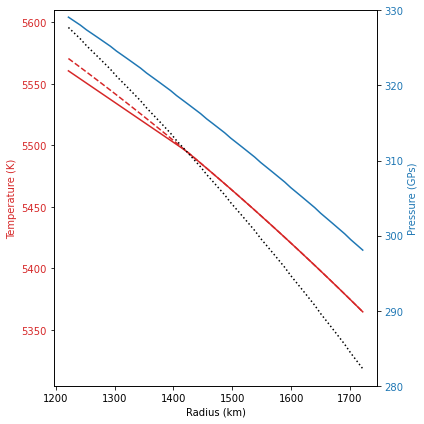

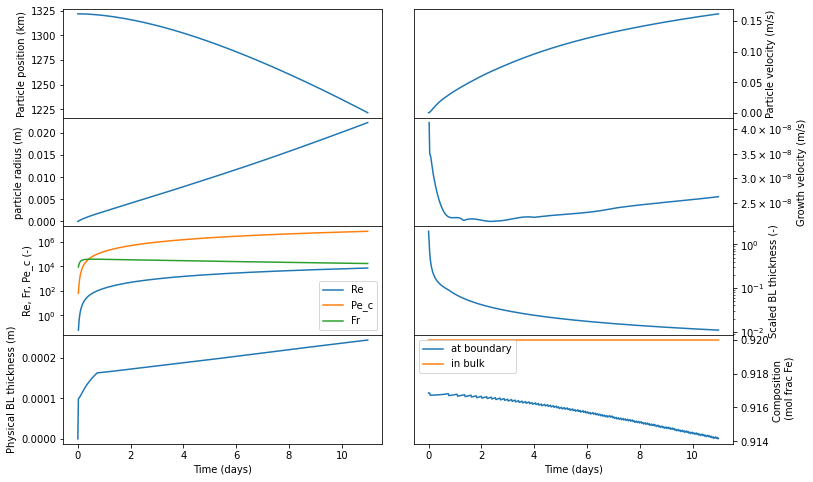

Particle radii between 0.0266 and 9.07e-06 m


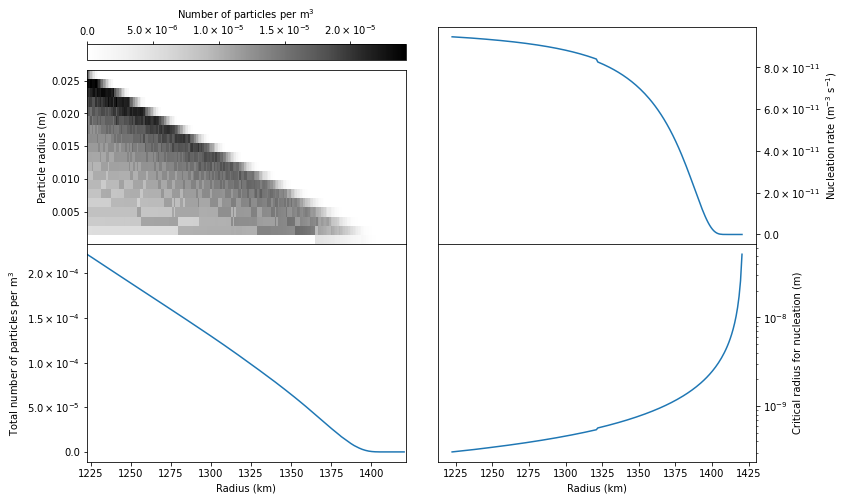

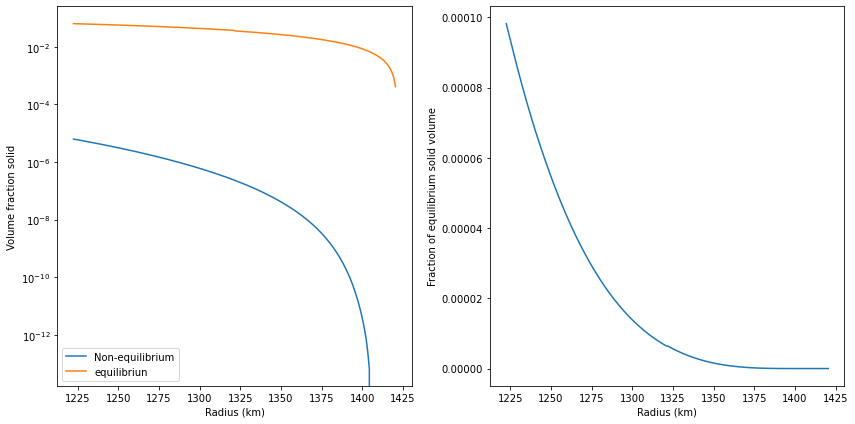

In [7]:
data_from_file = load_case_data("data.pickle")
# Plot P-T-R for reference. This is slow
plot_case_setup(**data_from_file)
# Plot solution from 'middle' of layer
plot_case_single_solution(100, data_from_file)
# Crystal density and nucleation
plot_case_csd_nuc(**data_from_file)
plot_case_solid_frac(**data_from_file)